In [222]:
import pandas as pd
import numpy as np
import os
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

In [223]:
clients = pd.read_csv('.\data\clients.csv')
products = pd.read_csv('.\data\products.csv')
stocks = pd.read_csv('.\data\stocks.csv')
stores = pd.read_csv('.\data\stores.csv')
transactions = pd.read_csv('./data/transactions.csv')

In [224]:
print('clients: ', clients.columns)
print('products: ', products.columns)
print('stocks: ',stocks.columns)
print('stores: ',stores.columns)
print('transactions: ', transactions.columns)

clients:  Index(['ClientID', 'ClientSegment', 'ClientCountry', 'ClientOptINEmail',
       'ClientOptINPhone', 'ClientGender', 'Age'],
      dtype='object')
products:  Index(['ProductID', 'Category', 'FamilyLevel1', 'FamilyLevel2', 'Universe'], dtype='object')
stocks:  Index(['StoreCountry', 'ProductID', 'Quantity'], dtype='object')
stores:  Index(['StoreID', 'StoreCountry'], dtype='object')
transactions:  Index(['ClientID', 'ProductID', 'SaleTransactionDate', 'StoreID', 'Quantity',
       'SalesNetAmountEuro'],
      dtype='object')


In [123]:
stores['StoreID'].unique().size

606

In [110]:
transactions = transactions.sort_values(by='ClientID')

In [136]:
transactions.columns

Index(['ClientID', 'ProductID', 'SaleTransactionDate', 'StoreID', 'Quantity',
       'SalesNetAmountEuro'],
      dtype='object')

## Transaction Clustering (Same Client, Same date, different products)

In [142]:
grouped_df = transactions.groupby(['ClientID', 'SaleTransactionDate']).agg(
    total_quantity=('Quantity', 'sum'), 
    total_amount_spent=('SalesNetAmountEuro', 'sum'),
    transaction_count=('ProductID', 'count')
).reset_index()

# Display the grouped DataFrame
# grouped_df.head(25)

### Product life-cycle

In [152]:
# Step 1: Group by 'ClientID' and 'ProductID' and count the unique 'SaleTransactionDate'
count_dates = transactions.groupby(['ClientID', 'ProductID'])['SaleTransactionDate'].nunique().reset_index()

# Step 2: Filter for rows where 'SaleTransactionDate' count is greater than 1
multiple_dates = count_dates[count_dates['SaleTransactionDate'] > 1]

# Step 3: Merge back to get the original rows
result = transactions.merge(multiple_dates[['ClientID', 'ProductID']], on=['ClientID', 'ProductID'], how='inner')

# Display the result (rows where the same product was bought on different dates)
result.head()


,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity,SalesNetAmountEuro
0,2497726585282787281,5103640511191568912,2023-09-20 00:00:00+00:00,1450109522794525790,1,5.99
1,3913817537779196185,8573693021421318503,2024-01-23 00:00:00+00:00,3600233866627167751,1,10.99
2,3183538914940113691,4264340979150525540,2024-07-20 00:00:00+00:00,9099531021898466037,4,50.97
3,970324337306047537,8984524553119131282,2023-04-21 00:00:00+00:00,1462011113949538177,1,5.99
4,4516550870786564525,6488384657788009650,2024-06-04 00:00:00+00:00,3325697448103923280,1,5.99


In [ ]:
# Step 1: Count the number of unique products per ClientID per SaleTransactionDate
grouped_df = transactions.groupby(['ClientID', 'SaleTransactionDate'])['ProductID'].nunique().reset_index()

# Step 2: Filter to find cases where the same ClientID bought more than 1 ProductID on the same date
multiple_products_df = grouped_df[grouped_df['ProductID'] > 1]

# Step 3: Merge back with the original DataFrame to get full transaction details
result_df = transactions.merge(multiple_products_df[['ClientID', 'SaleTransactionDate']], on=['ClientID', 'SaleTransactionDate'], how='inner')

# Step 4: Sort by ClientID, SaleTransactionDate, and ProductID
result_df = result_df.sort_values(by=['ClientID', 'SaleTransactionDate', 'ProductID']).reset_index(drop=True)

# Display the result
result_df.head(25)

,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity,SalesNetAmountEuro
0,487831788379074,2820126687947308401,2023-06-15 00:00:00+00:00,5202366601222773915,2,9.99
1,487831788379074,5814271529755388521,2023-06-15 00:00:00+00:00,5202366601222773915,2,8.99
2,487831788379074,596160146527302814,2023-11-15 00:00:00+00:00,5202366601222773915,1,3.99
3,487831788379074,3245181039283805384,2023-11-15 00:00:00+00:00,5202366601222773915,2,4.99
4,487831788379074,845645642533440388,2023-11-16 00:00:00+00:00,5202366601222773915,3,15.98
5,487831788379074,4772494314287191459,2023-11-16 00:00:00+00:00,5202366601222773915,4,14.97
6,624987180068091,4088240615781117851,2024-02-13 00:00:00+00:00,3325697448103923280,1,16.99
7,624987180068091,6836501382109623577,2024-02-13 00:00:00+00:00,3325697448103923280,2,20.99
8,633157752238300,7351594082589762847,2024-12-19 00:00:00+00:00,7242889412692100661,2,25.99
9,633157752238300,7824611703074545864,2024-12-19 00:00:00+00:00,7242889412692100661,1,76.99


## Client Spending

In [112]:
client_summary = transactions.groupby('ClientID').agg(
    TransactionCount=('ClientID', 'size'),  # Counts number of transactions for each ClientID
    TotalAmountSpent=('SalesNetAmountEuro', 'sum')      # Sums the 'Amount' column for each ClientID
).reset_index()

In [113]:
client_summary_sorted = client_summary.sort_values(by='TotalAmountSpent', ascending=False)
print(client_summary_sorted)

                   ClientID  TransactionCount  TotalAmountSpent
25827    784139077380372687             44460         557936.09
164153  4948726587055327420               319         504978.77
237327  7170141520984547731               971         339760.44
37204   1132261303486551948                 9         152320.92
115168  3468904384835684271                19         121431.77
...                     ...               ...               ...
130387  3928084724934230417                 1              0.01
138320  4170568209692584807                 1              0.01
137909  4157637604884968322                 1              0.01
113979  3433262166679570786                 1              0.01
83346   2513468324000536698                 1              0.01

[304929 rows x 3 columns]


## Product Combinations

In [ ]:
chunk_transactions = transactions[:100000]
client_products = chunk_transactions.groupby('ClientID')['ProductID'].apply(list).reset_index()

In [195]:
products.head()

,ProductID,Category,FamilyLevel1,FamilyLevel2,Universe
0,43220326960179274,Football,Ball,Nike Ordem V,Women
1,622915065731236396,Football,Ball,Nike Ordem V,Men
2,2020543468978812774,Football,Shorts,Nike Dri-FIT,Women
3,600002891277549143,Football,Shorts,Nike Dri-FIT,Women
4,6150916997899913693,Football,Shorts,Nike Dri-FIT,Men


In [214]:

def combination_items(n=2, df=chunk_transactions, products_df=products):    
    product_combinations = []

    # Create combinations for each client
    for prod in df.groupby('ClientID')['ProductID'].apply(list):
        if len(prod) >= n:
            product_combinations.extend(combinations(sorted(prod), n))

    # Step 3: Create a DataFrame with the product combinations
    df_combinations = pd.DataFrame(product_combinations, columns=[f'ProductID_{i+1}' for i in range(n)])

    # Step 4: Count occurrences of each combination
    product_combination_counts = df_combinations.value_counts().reset_index(name='CombinationCount')

    # Step 5: Merge with products DataFrame to get product names for each ProductID
    for i in range(n):
        product_combination_counts = product_combination_counts.merge(
            products_df[['ProductID', 'Category', 'FamilyLevel1', 'FamilyLevel2']], 
            left_on=f'ProductID_{i+1}', right_on='ProductID', how='left'
        ).rename(columns={'Category': f'ProductName_{i+1}', 'FamilyLevel2': f'FamilyLevel2_{i+1}'}).drop('ProductID', axis=1)

    # Step 6: Sort by CombinationCount
    sorted_product_combinations = product_combination_counts.sort_values(by='CombinationCount', ascending=False)

    # Step 7: Create the combination tuple for FamilyLevel2 columns
    sorted_product_combinations['Combination'] = list(zip(sorted_product_combinations['FamilyLevel2_1'], sorted_product_combinations['FamilyLevel2_2']))

    # Step 8: Filter out relevant columns for plotting (Combination and CombinationCount)
    combination_counts = sorted_product_combinations[['Combination', 'CombinationCount']]

    return combination_counts

def plot_combinations(df):
    # Create the plot with tuples of FamilyLevel2 as x-axis
    plt.figure(figsize=(12, 6))
    
    # Create a barplot
    sns.barplot(x='Combination', y='CombinationCount', data=df, palette='Blues_d')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha="right")

    # Set the plot labels and title
    plt.xlabel('Product Combinations (FamilyLevel2_x, FamilyLevel2_y)')
    plt.ylabel('Combination Count')
    plt.title('Most Frequent Product Combinations')
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [215]:
# Display the result

combination_2 = combination_items(2)
# combination_3 = combination_items(3)
# combination_4 = combination_items(4)


In [216]:
combination_2.head()

,Combination,CombinationCount
0,"(Nike Air Zoom BB NXT, Adidas Telstar 18)",462
1,"(Spalding NBA Official Game Ball, Nike Air Zoo...",462
2,"(Spalding NBA Official Game Ball, Adidas Telst...",441
5,"(Nike Air Zoom BB NXT, Nike Air Zoom BB NXT)",440
3,"(Spalding NBA Official Game Ball, Nike Air Zoo...",440


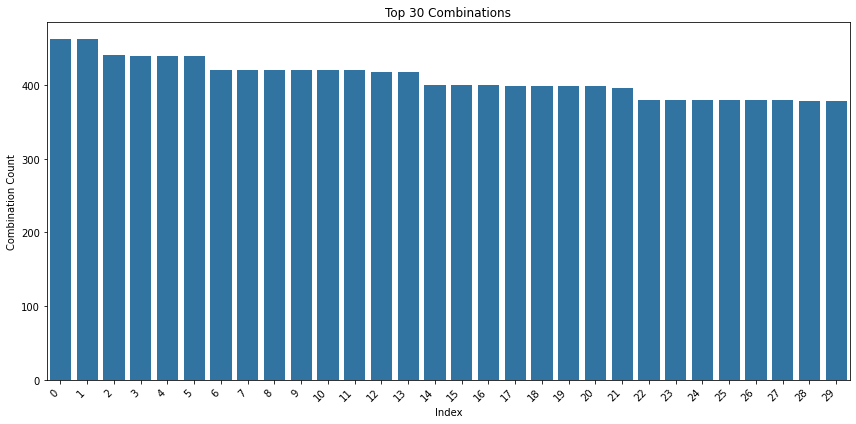

In [221]:
# Reset index to make plotting easier
plot_data = combination_2.head(30).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=plot_data.index, y=plot_data['CombinationCount'])
plt.title('Top 30 Combinations')
plt.xlabel('Index')
plt.ylabel('Combination Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()